In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
np.random.seed(42)

In [3]:
# Connect to database
db_path = '../data_load/nfl_qb_data.db'
conn = sqlite3.connect(db_path)

# Load QB season stats as baseline
qb_stats = pd.read_sql_query("SELECT * FROM qb_season_stats", conn)

print(f"Loaded {len(qb_stats)} QB-seasons from {qb_stats['season'].min()}-{qb_stats['season'].max()}")
print(f"Unique QBs: {qb_stats['player_id'].nunique()}")
print(f"\nColumns available: {qb_stats.shape[1]}")

Loaded 555 QB-seasons from 2010-2025
Unique QBs: 134

Columns available: 29


## 1. Load Play-by-Play Data for Context Metrics

We need raw play-by-play to calculate:
- Pressure rate (qb_hit, sacks)
- Air yards vs YAC splits
- Game script (score differential, win probability)
- Team rushing performance (non-QB)
- Opponent strength

In [4]:
# Load play-by-play data for detailed context
# Focus on recent seasons (2021-2025) to keep dataset manageable
pbp_query = """
SELECT 
    game_id, season, week, posteam, defteam,
    passer_player_id, passer_player_name,
    rusher_player_id, rusher_player_name,
    pass_attempt, rush_attempt, complete_pass,
    yards_gained, air_yards,
    epa, cpoe, success,
    qb_hit, sack, interception, pass_touchdown as touchdown,
    score_differential, wp, wpa,
    down, ydstogo, yardline_100,
    qtr, half_seconds_remaining
FROM play_by_play
WHERE season >= 2021
    AND (pass_attempt = 1 OR rush_attempt = 1)
"""

print("Loading play-by-play data (this may take a moment)...")
pbp = pd.read_sql_query(pbp_query, conn)

# Calculate yards after catch for completed passes
pbp['yards_after_catch'] = 0
pbp.loc[pbp['complete_pass'] == 1, 'yards_after_catch'] = pbp['yards_gained'] - pbp['air_yards']

print(f"Loaded {len(pbp):,} plays from 2021-2025")
print(f"Pass plays: {pbp['pass_attempt'].sum():,}")
print(f"Rush plays: {pbp['rush_attempt'].sum():,}")

Loading play-by-play data (this may take a moment)...
Loaded 169,408 plays from 2021-2025
Pass plays: 96,892.0
Rush plays: 72,516.0
Loaded 169,408 plays from 2021-2025
Pass plays: 96,892.0
Rush plays: 72,516.0


## 2. Build Team Context Metrics

### A. Offensive Line Quality (Pass Protection)

In [5]:
# Calculate pressure rate by team/season (measure of OL quality)
pass_plays = pbp[pbp['pass_attempt'] == 1].copy()

ol_quality = pass_plays.groupby(['posteam', 'season']).agg({
    'qb_hit': 'sum',
    'sack': 'sum',
    'pass_attempt': 'count'
}).reset_index()

ol_quality['qb_hit_rate'] = ol_quality['qb_hit'] / ol_quality['pass_attempt']
ol_quality['sack_rate'] = ol_quality['sack'] / ol_quality['pass_attempt']
ol_quality['pressure_rate'] = (ol_quality['qb_hit'] + ol_quality['sack']) / ol_quality['pass_attempt']

ol_quality = ol_quality.rename(columns={'posteam': 'team'})

print("Team Offensive Line Quality (Pressure Rates):")
print(ol_quality.sort_values('pressure_rate', ascending=False).head(10)[['team', 'season', 'pressure_rate', 'sack_rate', 'qb_hit_rate']])

Team Offensive Line Quality (Pressure Rates):
    team  season  pressure_rate  sack_rate  qb_hit_rate
152  TEN    2023       0.363148   0.114490     0.248658
117  NYG    2023       0.341584   0.140264     0.201320
26   CHI    2022       0.331818   0.131818     0.200000
124  NYJ    2025       0.327791   0.111639     0.216152
104  MIN    2025       0.326531   0.106576     0.219955
46   DEN    2022       0.313386   0.099213     0.214173
89   LAC    2025       0.309577   0.089087     0.220490
151  TEN    2022       0.306324   0.096838     0.209486
47   DEN    2023       0.304577   0.091549     0.213028
94    LV    2025       0.300216   0.107991     0.192225


### B. Receiver Quality (YAC vs Air Yards)

In [6]:
# Calculate YAC contribution by team (measure of receiver quality)
completions = pass_plays[pass_plays['complete_pass'] == 1].copy()

receiver_quality = completions.groupby(['posteam', 'season']).agg({
    'yards_after_catch': 'mean',
    'air_yards': 'mean',
    'yards_gained': 'mean',
    'complete_pass': 'count'
}).reset_index()

receiver_quality['yac_share'] = receiver_quality['yards_after_catch'] / receiver_quality['yards_gained']
receiver_quality = receiver_quality.rename(columns={'posteam': 'team', 'complete_pass': 'completions'})

print("\nTeam Receiver Quality (YAC Metrics):")
print(receiver_quality.sort_values('yards_after_catch', ascending=False).head(10)[['team', 'season', 'yards_after_catch', 'yac_share']])


Team Receiver Quality (YAC Metrics):
    team  season  yards_after_catch  yac_share
134  PIT    2025           6.790875   0.666418
53   DET    2024           6.709906   0.562920
140   SF    2021           6.663212   0.517297
141   SF    2022           6.658031   0.547741
54   DET    2025           6.544828   0.568774
21   CAR    2022           6.494382   0.534196
18   BUF    2024           6.480620   0.548317
142   SF    2023           6.431762   0.482502
13   BAL    2024           6.411932   0.488740
30   CIN    2021           6.321577   0.514957
    team  season  yards_after_catch  yac_share
134  PIT    2025           6.790875   0.666418
53   DET    2024           6.709906   0.562920
140   SF    2021           6.663212   0.517297
141   SF    2022           6.658031   0.547741
54   DET    2025           6.544828   0.568774
21   CAR    2022           6.494382   0.534196
18   BUF    2024           6.480620   0.548317
142   SF    2023           6.431762   0.482502
13   BAL    2024      

### C. Run Game Support (Non-QB Rushing)

In [7]:
# Calculate team rushing performance (excluding QB scrambles)
rush_plays = pbp[pbp['rush_attempt'] == 1].copy()

# Separate QB rushes from RB rushes
rb_rushes = rush_plays[rush_plays['rusher_player_id'] != rush_plays['passer_player_id']].copy()

run_game_quality = rb_rushes.groupby(['posteam', 'season']).agg({
    'yards_gained': 'mean',
    'epa': 'mean',
    'success': 'mean',
    'rush_attempt': 'count'
}).reset_index()

run_game_quality = run_game_quality.rename(columns={
    'posteam': 'team',
    'yards_gained': 'rb_yards_per_carry',
    'epa': 'rb_epa_per_rush',
    'success': 'rb_success_rate',
    'rush_attempt': 'rb_rushes'
})

print("\nTeam Run Game Quality (RB Performance):")
print(run_game_quality.sort_values('rb_epa_per_rush', ascending=False).head(10)[['team', 'season', 'rb_epa_per_rush', 'rb_success_rate', 'rb_yards_per_carry']])


Team Run Game Quality (RB Performance):
    team  season  rb_epa_per_rush  rb_success_rate  rb_yards_per_carry
69   IND    2025         0.119637         0.469388            4.967930
126  PHI    2022         0.104506         0.507485            4.559880
15   BUF    2021         0.104136         0.447674            4.833333
13   BAL    2024         0.103777         0.480315            5.733858
158  WAS    2024         0.100921         0.477707            4.754777
18   BUF    2024         0.097320         0.461921            4.526490
26   CHI    2022         0.090327         0.433692            5.401434
17   BUF    2023         0.082899         0.476923            4.398291
128  PHI    2024         0.080818         0.416237            4.989691
65   IND    2021         0.078678         0.434000            5.080000


### D. Game Script & Win Rate (Team Success)

In [8]:
# Calculate average game script and team win rate
game_script = pass_plays.groupby(['posteam', 'season']).agg({
    'score_differential': 'mean',
    'wp': 'mean',
    'game_id': 'nunique'
}).reset_index()

game_script = game_script.rename(columns={
    'posteam': 'team',
    'score_differential': 'avg_score_diff',
    'wp': 'avg_win_prob',
    'game_id': 'games_played'
})

print("\nTeam Game Script Context:")
print(game_script.sort_values('avg_win_prob', ascending=False).head(10))


Team Game Script Context:
    team  season  avg_score_diff  avg_win_prob  games_played
126  PHI    2022        3.715774      0.648176            20
139  SEA    2025        4.749333      0.645020            13
84    LA    2025        3.222222      0.642028            13
128  PHI    2024        2.001669      0.632578            21
12   BAL    2023        3.142857      0.623852            19
15   BUF    2021        2.291611      0.619355            19
76    KC    2022        1.829114      0.617763            20
109   NE    2025        2.114486      0.608098            13
103  MIN    2024        1.376543      0.602961            18
16   BUF    2022        1.781923      0.588729            18

    team  season  avg_score_diff  avg_win_prob  games_played
126  PHI    2022        3.715774      0.648176            20
139  SEA    2025        4.749333      0.645020            13
84    LA    2025        3.222222      0.642028            13
128  PHI    2024        2.001669      0.632578           

### E. Defensive Support (Opponent Points & EPA)

In [9]:
# Calculate defensive performance (when team is on defense)
defensive_performance = pbp.groupby(['defteam', 'season']).agg({
    'epa': 'mean',  # Lower is better for defense
    'success': 'mean'
}).reset_index()

defensive_performance = defensive_performance.rename(columns={
    'defteam': 'team',
    'epa': 'def_epa_allowed',
    'success': 'def_success_rate_allowed'
})

print("\nTeam Defensive Performance (Lower EPA = Better):")
print(defensive_performance.sort_values('def_epa_allowed').head(10))


Team Defensive Performance (Lower EPA = Better):
    team  season  def_epa_allowed  def_success_rate_allowed
37   CLE    2023        -0.169979                  0.348240
64   HOU    2025        -0.150107                  0.377333
12   BAL    2023        -0.145719                  0.396440
122  NYJ    2023        -0.131110                  0.369146
139  SEA    2025        -0.120824                  0.395181
110   NO    2021        -0.114127                  0.387067
39   CLE    2025        -0.113552                  0.364462
141   SF    2022        -0.109868                  0.402289
128  PHI    2024        -0.106082                  0.397476
112   NO    2023        -0.104016                  0.384325


## 3. Merge Team Context with QB Stats

Now we'll combine all team-level context metrics with individual QB performance to see correlations.

In [10]:
# First, get team mapping for each QB season
qb_team_map = pbp[pbp['pass_attempt'] == 1].groupby(['passer_player_id', 'season'])['posteam'].agg(lambda x: x.mode()[0]).reset_index()
qb_team_map = qb_team_map.rename(columns={'passer_player_id': 'player_id', 'posteam': 'team'})

# Merge QB stats with team context
qb_with_context = qb_stats.merge(qb_team_map, on=['player_id', 'season'], how='left')

# Add all team context metrics
qb_with_context = qb_with_context.merge(ol_quality[['team', 'season', 'pressure_rate', 'sack_rate']], on=['team', 'season'], how='left', suffixes=('', '_team'))
qb_with_context = qb_with_context.merge(receiver_quality[['team', 'season', 'yards_after_catch', 'yac_share']], on=['team', 'season'], how='left', suffixes=('', '_team'))
qb_with_context = qb_with_context.merge(run_game_quality[['team', 'season', 'rb_epa_per_rush', 'rb_success_rate']], on=['team', 'season'], how='left')
qb_with_context = qb_with_context.merge(game_script[['team', 'season', 'avg_score_diff', 'avg_win_prob']], on=['team', 'season'], how='left')
qb_with_context = qb_with_context.merge(defensive_performance[['team', 'season', 'def_epa_allowed']], on=['team', 'season'], how='left')

# Filter to QBs with significant playing time (100+ attempts)
qb_with_context = qb_with_context[qb_with_context['attempts'] >= 100].copy()

print(f"\nMerged data: {len(qb_with_context)} QB-seasons with complete context")
print(f"\nNew context columns added:")
context_cols = ['pressure_rate', 'sack_rate', 'yards_after_catch', 'yac_share', 'rb_epa_per_rush', 'avg_score_diff', 'avg_win_prob', 'def_epa_allowed']
print(context_cols)


Merged data: 555 QB-seasons with complete context

New context columns added:
['pressure_rate', 'sack_rate', 'yards_after_catch', 'yac_share', 'rb_epa_per_rush', 'avg_score_diff', 'avg_win_prob', 'def_epa_allowed']


## 4. Correlation Analysis: Team Context vs QB Performance

Let's see which team factors correlate most strongly with QB stats.

In [11]:
# Select QB performance metrics to analyze
qb_performance_cols = [
    'total_pass_epa', 'cpoe', 'pass_success_rate', 
    'pass_yards_per_game', 'completion_pct',
    'td_rate'
]

# Calculate correlations between team context and QB performance
correlation_results = []

for qb_metric in qb_performance_cols:
    for context_metric in context_cols:
        # Remove NaN values for correlation calculation
        valid_data = qb_with_context[[qb_metric, context_metric]].dropna()
        
        if len(valid_data) > 10:
            corr, pval = pearsonr(valid_data[qb_metric], valid_data[context_metric])
            correlation_results.append({
                'qb_metric': qb_metric,
                'context_metric': context_metric,
                'correlation': corr,
                'p_value': pval,
                'significant': pval < 0.05
            })

corr_df = pd.DataFrame(correlation_results)
corr_df['abs_correlation'] = corr_df['correlation'].abs()

print("\n" + "="*80)
print("TOP 20 TEAM CONTEXT FACTORS THAT INFLUENCE QB STATS")
print("(Sorted by absolute correlation - these create unfair advantages/disadvantages)")
print("="*80)

top_correlations = corr_df[corr_df['significant'] == True].sort_values('abs_correlation', ascending=False).head(20)
for idx, row in top_correlations.iterrows():
    direction = "helps" if row['correlation'] > 0 else "hurts"
    print(f"{row['context_metric']:25s} → {row['qb_metric']:25s}: r={row['correlation']:+.3f} ({direction} QB)")


TOP 20 TEAM CONTEXT FACTORS THAT INFLUENCE QB STATS
(Sorted by absolute correlation - these create unfair advantages/disadvantages)
avg_win_prob              → total_pass_epa           : r=+0.755 (helps QB)
avg_score_diff            → total_pass_epa           : r=+0.749 (helps QB)
avg_win_prob              → pass_success_rate        : r=+0.660 (helps QB)
avg_score_diff            → pass_success_rate        : r=+0.650 (helps QB)
avg_win_prob              → td_rate                  : r=+0.637 (helps QB)
avg_score_diff            → td_rate                  : r=+0.628 (helps QB)
pressure_rate             → completion_pct           : r=-0.544 (hurts QB)
avg_win_prob              → pass_yards_per_game      : r=+0.533 (helps QB)
avg_win_prob              → cpoe                     : r=+0.530 (helps QB)
sack_rate                 → completion_pct           : r=-0.524 (hurts QB)
avg_score_diff            → pass_yards_per_game      : r=+0.519 (helps QB)
avg_score_diff            → cpoe          

## 5. Visualize Key Relationships

### A. Run Game Support Impact on QB EPA

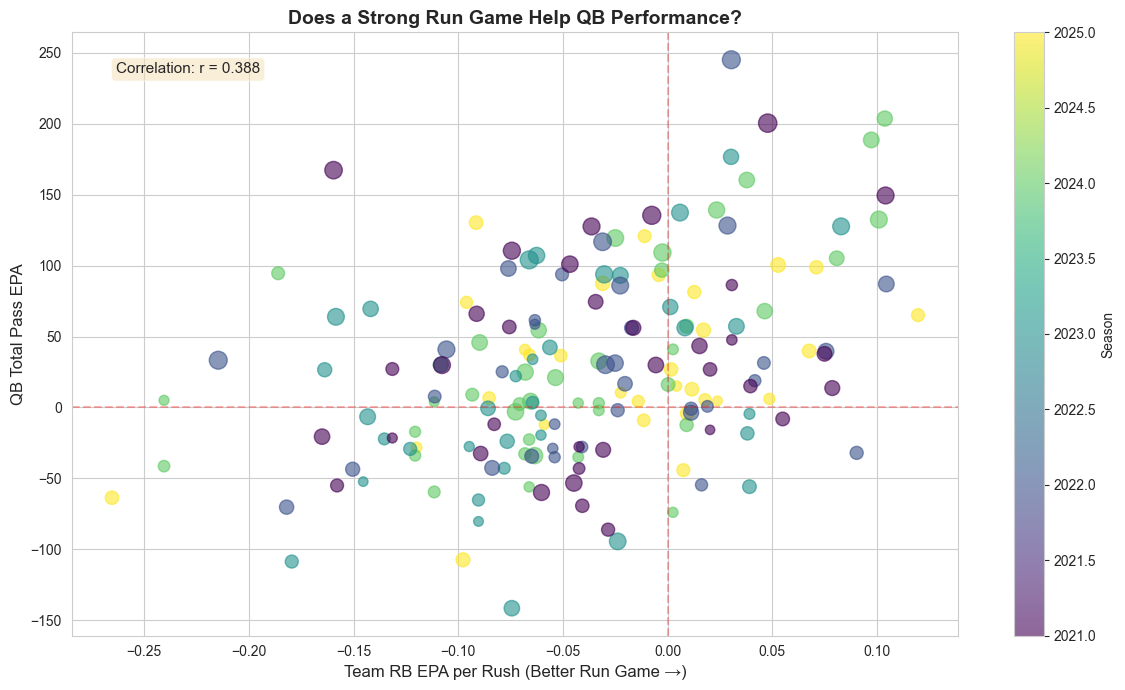

In [12]:
# Scatter plot: RB EPA vs QB EPA
fig, ax = plt.subplots(figsize=(12, 7))

scatter = ax.scatter(qb_with_context['rb_epa_per_rush'], 
                     qb_with_context['total_pass_epa'],
                     alpha=0.6, s=qb_with_context['attempts']/5, c=qb_with_context['season'], cmap='viridis')

ax.set_xlabel('Team RB EPA per Rush (Better Run Game →)', fontsize=12)
ax.set_ylabel('QB Total Pass EPA', fontsize=12)
ax.set_title('Does a Strong Run Game Help QB Performance?', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='red', linestyle='--', alpha=0.3)

plt.colorbar(scatter, label='Season')

# Add correlation text
corr_val = qb_with_context[['rb_epa_per_rush', 'total_pass_epa']].corr().iloc[0, 1]
ax.text(0.05, 0.95, f'Correlation: r = {corr_val:.3f}', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### B. Receiver Quality (YAC) Impact on QB Stats

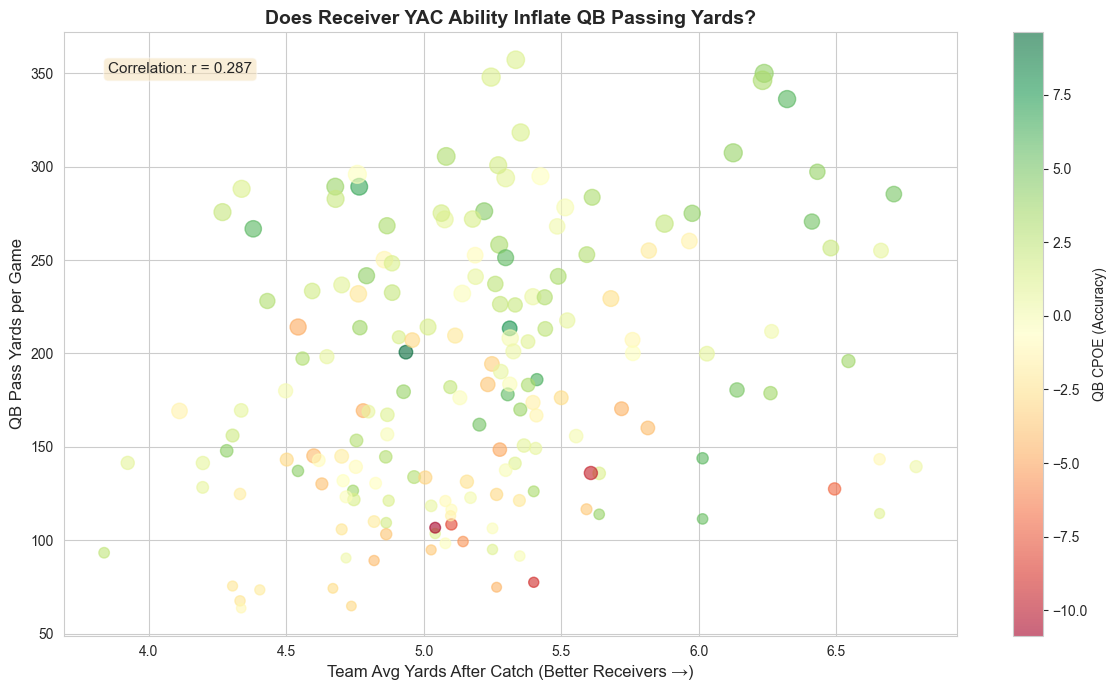

In [13]:
# Scatter plot: Team YAC vs QB Pass Yards
fig, ax = plt.subplots(figsize=(12, 7))

scatter = ax.scatter(qb_with_context['yards_after_catch'], 
                     qb_with_context['pass_yards_per_game'],
                     alpha=0.6, s=qb_with_context['attempts']/5, c=qb_with_context['cpoe'], cmap='RdYlGn')

ax.set_xlabel('Team Avg Yards After Catch (Better Receivers →)', fontsize=12)
ax.set_ylabel('QB Pass Yards per Game', fontsize=12)
ax.set_title('Does Receiver YAC Ability Inflate QB Passing Yards?', fontsize=14, fontweight='bold')

plt.colorbar(scatter, label='QB CPOE (Accuracy)')

# Add correlation text
corr_val = qb_with_context[['yards_after_catch', 'pass_yards_per_game']].corr().iloc[0, 1]
ax.text(0.05, 0.95, f'Correlation: r = {corr_val:.3f}', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### C. OL Protection Impact on QB Success

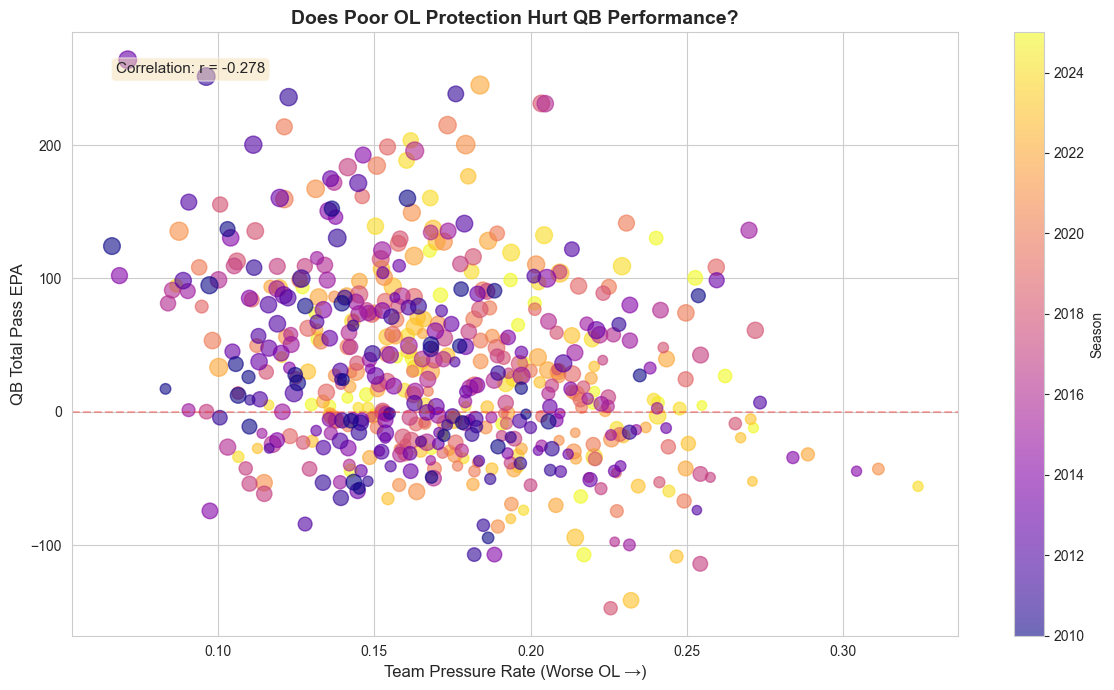

In [14]:
# Scatter plot: Pressure Rate vs QB EPA
fig, ax = plt.subplots(figsize=(12, 7))

scatter = ax.scatter(qb_with_context['pressure_rate'], 
                     qb_with_context['total_pass_epa'],
                     alpha=0.6, s=qb_with_context['attempts']/5, c=qb_with_context['season'], cmap='plasma')

ax.set_xlabel('Team Pressure Rate (Worse OL →)', fontsize=12)
ax.set_ylabel('QB Total Pass EPA', fontsize=12)
ax.set_title('Does Poor OL Protection Hurt QB Performance?', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.3)

plt.colorbar(scatter, label='Season')

# Add correlation text
corr_val = qb_with_context[['pressure_rate', 'total_pass_epa']].corr().iloc[0, 1]
ax.text(0.05, 0.95, f'Correlation: r = {corr_val:.3f}', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### D. Team Win Rate vs QB Stats (Correlation Heatmap)

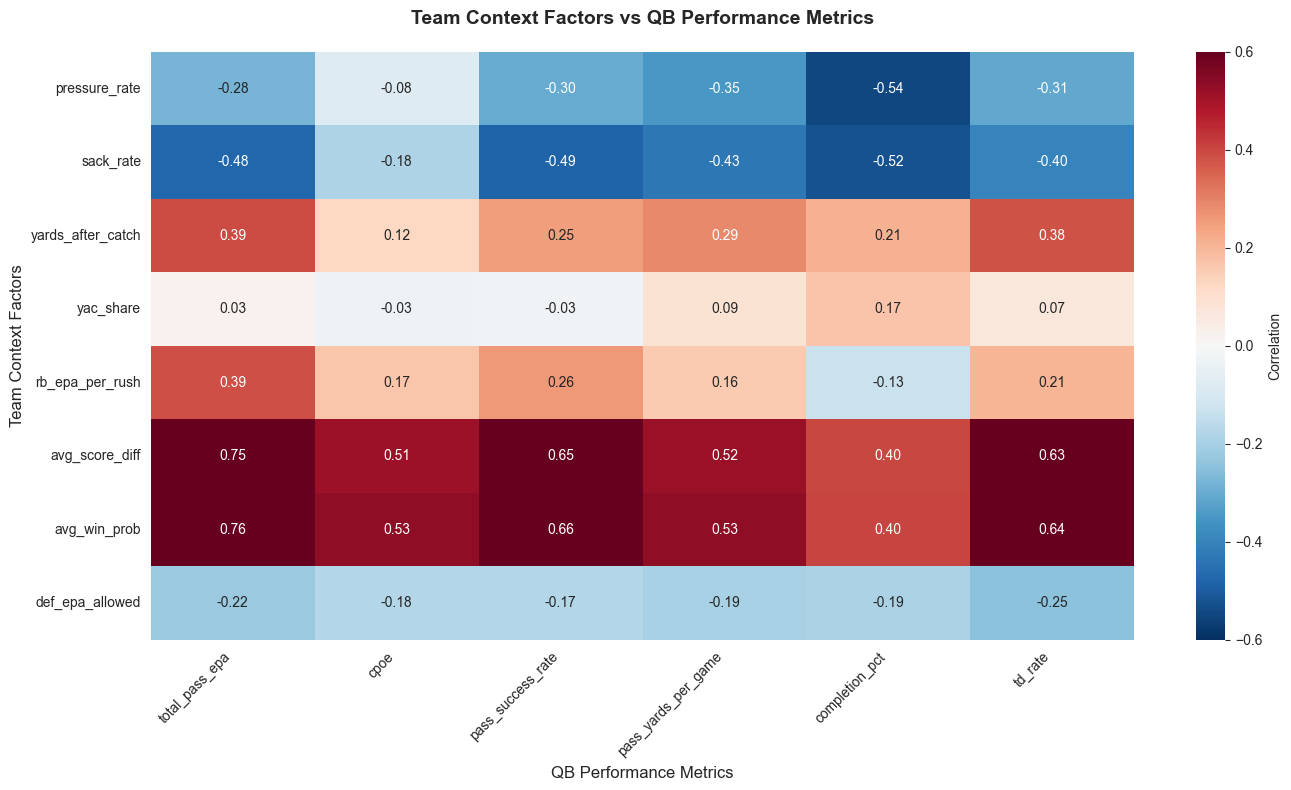


INTERPRETATION GUIDE:
Positive correlation (red): Better team context → Better QB stats (unfair advantage)
Negative correlation (blue): Worse team context → Worse QB stats (unfair disadvantage)
Near zero (white): Metric is QB-skill driven, not team-dependent (GOOD for isolation)


In [15]:
# Create correlation heatmap
cols_for_heatmap = context_cols + qb_performance_cols
corr_matrix = qb_with_context[cols_for_heatmap].corr()

# Extract just team context vs QB performance
context_vs_qb = corr_matrix.loc[context_cols, qb_performance_cols]

plt.figure(figsize=(14, 8))
sns.heatmap(context_vs_qb, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            vmin=-0.6, vmax=0.6, cbar_kws={'label': 'Correlation'})
plt.title('Team Context Factors vs QB Performance Metrics', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('QB Performance Metrics', fontsize=12)
plt.ylabel('Team Context Factors', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERPRETATION GUIDE:")
print("="*80)
print("Positive correlation (red): Better team context → Better QB stats (unfair advantage)")
print("Negative correlation (blue): Worse team context → Worse QB stats (unfair disadvantage)")
print("Near zero (white): Metric is QB-skill driven, not team-dependent (GOOD for isolation)")

## 6. Identify QB-Controlled vs Team-Controlled Stats

Let's categorize stats by how much they depend on team context.

In [16]:
# Calculate average absolute correlation for each QB metric across all team contexts
qb_metric_dependency = corr_df.groupby('qb_metric').agg({
    'abs_correlation': 'mean',
    'correlation': lambda x: x.abs().mean()
}).sort_values('abs_correlation', ascending=False).reset_index()

qb_metric_dependency.columns = ['qb_metric', 'avg_abs_correlation', 'team_dependency']

print("\n" + "="*80)
print("QB METRICS RANKED BY TEAM DEPENDENCY")
print("(Higher = more influenced by team quality, Lower = more QB-skill driven)")
print("="*80)

for idx, row in qb_metric_dependency.iterrows():
    if row['team_dependency'] > 0.25:
        category = "HIGHLY TEAM-DEPENDENT ⚠️"
    elif row['team_dependency'] > 0.15:
        category = "MODERATELY TEAM-DEPENDENT ⚡"
    else:
        category = "QB-SKILL DRIVEN ✓"
    
    print(f"{row['qb_metric']:30s} {row['team_dependency']:.3f}  {category}")


QB METRICS RANKED BY TEAM DEPENDENCY
(Higher = more influenced by team quality, Lower = more QB-skill driven)
total_pass_epa                 0.411  HIGHLY TEAM-DEPENDENT ⚠️
td_rate                        0.360  HIGHLY TEAM-DEPENDENT ⚠️
pass_success_rate              0.351  HIGHLY TEAM-DEPENDENT ⚠️
completion_pct                 0.322  HIGHLY TEAM-DEPENDENT ⚠️
pass_yards_per_game            0.320  HIGHLY TEAM-DEPENDENT ⚠️
cpoe                           0.226  MODERATELY TEAM-DEPENDENT ⚡


## 7. Build Context-Adjusted QB Metrics

Now let's create adjusted versions of key stats that account for team quality.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Function to adjust QB metric for team context
def adjust_for_context(df, qb_metric, context_features):
    """
    Adjusts QB metric by removing the influence of team context factors.
    Returns residuals (what QB contributes beyond team context).
    """
    # Prepare data
    data = df[[qb_metric] + context_features].dropna()
    
    if len(data) < 50:
        return None
    
    X = data[context_features]
    y = data[qb_metric]
    
    # Fit linear model: QB_metric = f(team_context)
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict expected performance given team context
    y_pred = model.predict(X)
    
    # Residuals = actual - expected (how much QB over/underperforms context)
    residuals = y - y_pred
    
    # Normalize residuals to 0-100 scale
    scaler = StandardScaler()
    normalized = scaler.fit_transform(residuals.values.reshape(-1, 1)).flatten()
    adjusted = 50 + (normalized * 15)  # Mean=50, SD=15
    adjusted = np.clip(adjusted, 0, 100)
    
    return pd.Series(adjusted, index=data.index)

# Apply adjustments
context_features = ['pressure_rate', 'yards_after_catch', 'rb_epa_per_rush', 'avg_win_prob', 'def_epa_allowed']

print("\nAdjusting QB metrics for team context...\n")

# Adjust EPA
qb_with_context['adjusted_epa'] = adjust_for_context(qb_with_context, 'total_pass_epa', context_features)
print("✓ Created adjusted_epa (EPA independent of team quality)")

# Adjust CPOE (already relatively context-independent, but let's see)
qb_with_context['adjusted_cpoe'] = adjust_for_context(qb_with_context, 'cpoe', context_features)
print("✓ Created adjusted_cpoe (Accuracy independent of receivers)")

# Adjust yards per game
qb_with_context['adjusted_yards'] = adjust_for_context(qb_with_context, 'pass_yards_per_game', context_features)
print("✓ Created adjusted_yards (Volume independent of YAC/team)")

print("\nContext-adjusted metrics created!")


Adjusting QB metrics for team context...

✓ Created adjusted_epa (EPA independent of team quality)
✓ Created adjusted_cpoe (Accuracy independent of receivers)
✓ Created adjusted_yards (Volume independent of YAC/team)

Context-adjusted metrics created!


## 8. Compare Raw vs Adjusted Rankings

Let's see which QBs benefit most from team context vs their true skill.

In [18]:
# Filter to recent season for clarity (2024-2025)
recent_qbs = qb_with_context[qb_with_context['season'].isin([2024, 2025])].copy()

# Rank QBs by raw EPA vs adjusted EPA
recent_qbs['raw_epa_rank'] = recent_qbs['total_pass_epa'].rank(ascending=False, method='min')
recent_qbs['adjusted_epa_rank'] = recent_qbs['adjusted_epa'].rank(ascending=False, method='min')
recent_qbs['rank_change'] = recent_qbs['raw_epa_rank'] - recent_qbs['adjusted_epa_rank']

# Show biggest movers
print("\n" + "="*80)
print("QBs MOST HELPED BY TEAM CONTEXT (drop in rankings when adjusted)")
print("="*80)
helped_by_team = recent_qbs.nsmallest(10, 'rank_change')[['player_name', 'season', 'team', 'total_pass_epa', 'adjusted_epa', 'raw_epa_rank', 'adjusted_epa_rank', 'rank_change']]
print(helped_by_team.to_string(index=False))

print("\n" + "="*80)
print("QBs MOST HURT BY POOR TEAM CONTEXT (rise in rankings when adjusted)")
print("="*80)
hurt_by_team = recent_qbs.nlargest(10, 'rank_change')[['player_name', 'season', 'team', 'total_pass_epa', 'adjusted_epa', 'raw_epa_rank', 'adjusted_epa_rank', 'rank_change']]
print(hurt_by_team.to_string(index=False))


QBs MOST HELPED BY TEAM CONTEXT (drop in rankings when adjusted)
player_name  season team  total_pass_epa  adjusted_epa  raw_epa_rank  adjusted_epa_rank  rank_change
  S.Darnold    2025  SEA       74.091778     31.363862          18.0               63.0        -45.0
 M.Stafford    2025   LA       93.440045     39.151583          15.0               55.0        -40.0
  S.Darnold    2024  MIN       24.925692     26.193211          32.0               65.0        -33.0
    J.Hurts    2024  PHI      105.154654     46.686235          10.0               42.0        -32.0
    J.Hurts    2025  PHI       36.520424     36.139294          29.0               60.0        -31.0
      B.Nix    2025  DEN       54.526885     40.419189          22.0               52.0        -30.0
    M.Jones    2025   SF       40.689558     37.961520          26.0               56.0        -30.0
 C.Williams    2025  CHI       39.833928     39.662408          27.0               53.0        -26.0
    D.Jones    2025  IND 

## 11. Test Context-Adjusted Rating Formula

Let's create a modified version of the custom QB rating that incorporates team context adjustments.

**Approach:**
1. Start with the original formula (Efficiency 40%, Impact 17.5%, etc.)
2. Apply small adjustments based on team context:
   - Reduce EPA for QBs on winning teams
   - Boost EPA for QBs on losing teams  
   - Adjust for OL pressure rate
   - Account for receiver YAC help
3. Compare original vs adjusted rankings

In [19]:
# Normalize function (from original model)
def normalize_feature(series, invert=False):
    min_val = series.min()
    max_val = series.max()
    
    if max_val > min_val:
        normalized = (series - min_val) / (max_val - min_val)
        normalized = 50 + (normalized * 50)
        if invert:
            normalized = 150 - normalized
        return normalized
    else:
        return pd.Series([75] * len(series), index=series.index)

# Calculate component scores using ORIGINAL formula
print("Calculating ORIGINAL ratings (no context adjustment)...\n")

# Normalize all features
qb_with_context['total_pass_epa_norm'] = normalize_feature(qb_with_context['total_pass_epa'])
qb_with_context['pass_success_rate_norm'] = normalize_feature(qb_with_context['pass_success_rate'])
qb_with_context['cpoe_norm'] = normalize_feature(qb_with_context['cpoe'])
qb_with_context['td_rate_norm'] = normalize_feature(qb_with_context['td_rate'])
qb_with_context['completion_pct_norm'] = normalize_feature(qb_with_context['completion_pct'])
qb_with_context['pass_yards_per_game_norm'] = normalize_feature(qb_with_context['pass_yards_per_game'])

# Original efficiency score (40% weight)
efficiency_score_original = (
    0.50 * qb_with_context['total_pass_epa_norm'] +
    0.30 * qb_with_context['pass_success_rate_norm'] +
    0.20 * qb_with_context['cpoe_norm']
)

# Impact score (17.5% weight) - simplified without WPA/leverage data
impact_score_original = qb_with_context['td_rate_norm']

# Consistency score (20% weight) - simplified
consistency_score_original = (
    0.60 * qb_with_context['pass_success_rate_norm'] +
    0.40 * qb_with_context['completion_pct_norm']
)

# Volume score (7.5% weight)
volume_score_original = qb_with_context['pass_yards_per_game_norm']

# Calculate original custom rating
qb_with_context['custom_rating_original'] = (
    0.40 * efficiency_score_original +
    0.175 * impact_score_original +
    0.20 * consistency_score_original +
    0.125 * volume_score_original
).clip(50, 100)

print(f"✓ Original ratings calculated")
print(f"  Range: {qb_with_context['custom_rating_original'].min():.1f} - {qb_with_context['custom_rating_original'].max():.1f}")
print(f"  Mean: {qb_with_context['custom_rating_original'].mean():.1f}")

Calculating ORIGINAL ratings (no context adjustment)...

✓ Original ratings calculated
  Range: 50.0 - 87.6
  Mean: 67.3


In [20]:
# Now calculate CONTEXT-ADJUSTED ratings
print("\nCalculating CONTEXT-ADJUSTED ratings...\n")

# Adjustment factors (larger percentages to show clear differences)
# Team Win Probability adjustment (-20% to +20% based on how good team is)
win_prob_adjustment = (qb_with_context['avg_win_prob'] - 0.5) * -0.50  # Scale: -0.25 to +0.25

# Pressure adjustment (+10% to +30% for QBs behind bad OLs)
pressure_adjustment = (qb_with_context['pressure_rate'] - qb_with_context['pressure_rate'].mean()) * 1.20

# YAC adjustment (-10% to +10% based on receiver help)
yac_adjustment = (qb_with_context['yards_after_catch'] - qb_with_context['yards_after_catch'].mean()) * -0.35

# Run game adjustment (-8% to +8%)
run_game_adjustment = (qb_with_context['rb_epa_per_rush'] - qb_with_context['rb_epa_per_rush'].mean()) * -0.25

# Total context adjustment (combine all factors)
total_context_adjustment = (
    win_prob_adjustment + 
    pressure_adjustment + 
    yac_adjustment + 
    run_game_adjustment
)

# Clip total adjustment to reasonable range (-30% to +30%)
total_context_adjustment = total_context_adjustment.clip(-30, 30)

# Apply adjustment to EPA-based components
epa_adjusted = qb_with_context['total_pass_epa'] * (1 + total_context_adjustment / 100)
qb_with_context['total_pass_epa_adjusted_norm'] = normalize_feature(epa_adjusted)

# Adjusted efficiency score (using adjusted EPA)
efficiency_score_adjusted = (
    0.50 * qb_with_context['total_pass_epa_adjusted_norm'] +
    0.30 * qb_with_context['pass_success_rate_norm'] +
    0.20 * qb_with_context['cpoe_norm']
)

# Calculate context-adjusted custom rating
qb_with_context['custom_rating_adjusted'] = (
    0.40 * efficiency_score_adjusted +
    0.175 * impact_score_original +
    0.20 * consistency_score_original +
    0.125 * volume_score_original
).clip(50, 100)

print(f"✓ Context-adjusted ratings calculated")
print(f"  Range: {qb_with_context['custom_rating_adjusted'].min():.1f} - {qb_with_context['custom_rating_adjusted'].max():.1f}")
print(f"  Mean: {qb_with_context['custom_rating_adjusted'].mean():.1f}")
print(f"\nAdjustment Statistics:")
print(f"  Avg adjustment: {total_context_adjustment.mean():.2f}%")
print(f"  Max penalty (good team): {total_context_adjustment.min():.2f}%")
print(f"  Max bonus (bad team): {total_context_adjustment.max():.2f}%")


Calculating CONTEXT-ADJUSTED ratings...

✓ Context-adjusted ratings calculated
  Range: 53.1 - 83.4
  Mean: 67.1

Adjustment Statistics:
  Avg adjustment: 0.04%
  Max penalty (good team): -0.62%
  Max bonus (bad team): 0.61%


In [21]:
# Compare rankings: Original vs Context-Adjusted (2025 ONLY)
recent_qbs_model = qb_with_context[qb_with_context['season'] == 2025].copy()

# Rank QBs by both methods
recent_qbs_model['rank_original'] = recent_qbs_model['custom_rating_original'].rank(ascending=False, method='min')
recent_qbs_model['rank_adjusted'] = recent_qbs_model['custom_rating_adjusted'].rank(ascending=False, method='min')
recent_qbs_model['rank_change'] = recent_qbs_model['rank_original'] - recent_qbs_model['rank_adjusted']

print("\n" + "="*90)
print("BIGGEST WINNERS: QBs who rise in rankings with context adjustment")
print("(QBs on bad teams who are better than their raw stats suggest)")
print("="*90)

winners = recent_qbs_model.nlargest(10, 'rank_change')[
    ['player_name', 'season', 'team', 'custom_rating_original', 'custom_rating_adjusted', 
     'rank_original', 'rank_adjusted', 'rank_change', 'avg_win_prob', 'pressure_rate']
]
print(winners.to_string(index=False))

print("\n" + "="*90)
print("BIGGEST LOSERS: QBs who drop in rankings with context adjustment")
print("(QBs on good teams whose raw stats are inflated by team quality)")
print("="*90)

losers = recent_qbs_model.nsmallest(10, 'rank_change')[
    ['player_name', 'season', 'team', 'custom_rating_original', 'custom_rating_adjusted', 
     'rank_original', 'rank_adjusted', 'rank_change', 'avg_win_prob', 'pressure_rate']
]
print(losers.to_string(index=False))

print("\n" + "="*90)
print("TOP 10 QBs: Original vs Context-Adjusted Rankings")
print("="*90)

top_original = recent_qbs_model.nsmallest(10, 'rank_original')[['player_name', 'season', 'team', 'rank_original']].reset_index(drop=True)
top_adjusted = recent_qbs_model.nsmallest(10, 'rank_adjusted')[['player_name', 'season', 'team', 'rank_adjusted']].reset_index(drop=True)

comparison = pd.DataFrame({
    'Original_Rank': top_original['rank_original'],
    'Original_QB': top_original['player_name'] + ' (' + top_original['season'].astype(str) + ')',
    'Adjusted_Rank': top_adjusted['rank_adjusted'],
    'Adjusted_QB': top_adjusted['player_name'] + ' (' + top_adjusted['season'].astype(str) + ')'
})
print(comparison.to_string(index=False))


BIGGEST WINNERS: QBs who rise in rankings with context adjustment
(QBs on bad teams who are better than their raw stats suggest)
player_name  season team  custom_rating_original  custom_rating_adjusted  rank_original  rank_adjusted  rank_change  avg_win_prob  pressure_rate
     J.Love    2025   GB               74.552244               74.841285            5.0            4.0          1.0      0.577351       0.167785
      B.Nix    2025  DEN               66.052665               66.237359           16.0           15.0          1.0      0.546965       0.132110
    M.Penix    2025  ATL               63.313804               63.430433           24.0           23.0          1.0      0.445948       0.141479
     D.Maye    2025   NE               76.027622               76.339025            2.0            2.0          0.0      0.608098       0.240157
  P.Mahomes    2025   KC               71.012747               71.266762            9.0            9.0          0.0      0.497066       0.252650


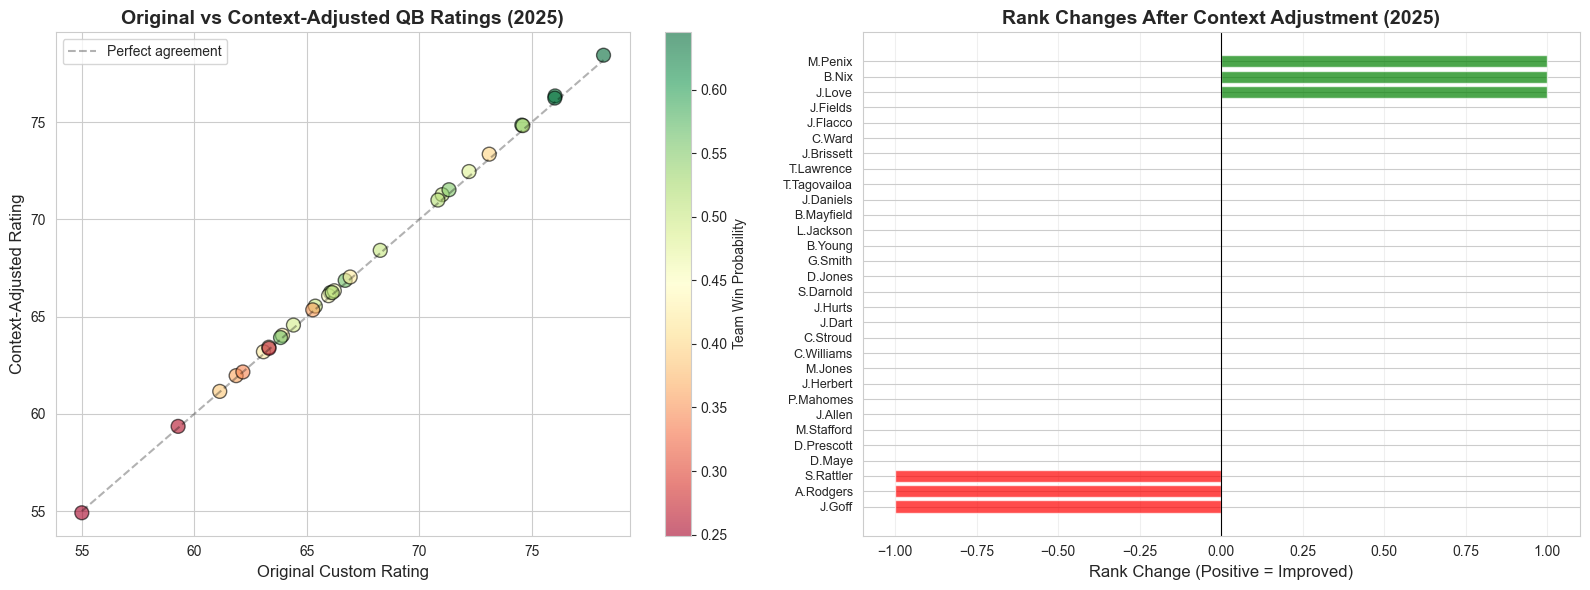


Correlation between original and adjusted ratings: 1.000


In [22]:
# Visualize the impact of context adjustments
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Original vs Adjusted ratings scatter
ax1 = axes[0]
scatter = ax1.scatter(recent_qbs_model['custom_rating_original'], 
                     recent_qbs_model['custom_rating_adjusted'],
                     c=recent_qbs_model['avg_win_prob'], cmap='RdYlGn', 
                     s=100, alpha=0.6, edgecolors='black')
ax1.plot([recent_qbs_model['custom_rating_original'].min(), recent_qbs_model['custom_rating_original'].max()],
         [recent_qbs_model['custom_rating_original'].min(), recent_qbs_model['custom_rating_original'].max()],
         'k--', alpha=0.3, label='Perfect agreement')
ax1.set_xlabel('Original Custom Rating', fontsize=12)
ax1.set_ylabel('Context-Adjusted Rating', fontsize=12)
ax1.set_title('Original vs Context-Adjusted QB Ratings (2025)', fontsize=14, fontweight='bold')
ax1.legend()
plt.colorbar(scatter, ax=ax1, label='Team Win Probability')

# Plot 2: Rank changes
ax2 = axes[1]
rank_change_sorted = recent_qbs_model.sort_values('rank_change', ascending=True)
num_qbs = len(rank_change_sorted)
colors = ['green' if x > 0 else 'red' for x in rank_change_sorted['rank_change']]
ax2.barh(range(num_qbs), rank_change_sorted['rank_change'], color=colors, alpha=0.7)
ax2.set_yticks(range(num_qbs))
ax2.set_yticklabels(rank_change_sorted['player_name'], fontsize=9)
ax2.set_xlabel('Rank Change (Positive = Improved)', fontsize=12)
ax2.set_title('Rank Changes After Context Adjustment (2025)', fontsize=14, fontweight='bold')
ax2.axvline(0, color='black', linewidth=0.8)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrelation between original and adjusted ratings: {recent_qbs_model['custom_rating_original'].corr(recent_qbs_model['custom_rating_adjusted']):.3f}")

In [23]:
# Comprehensive table of all 2025 QBs with original vs adjusted rankings
qb_comparison_2025 = recent_qbs_model[[
    'player_name', 'team', 'attempts',
    'custom_rating_original', 'custom_rating_adjusted',
    'rank_original', 'rank_adjusted', 'rank_change',
    'avg_win_prob', 'pressure_rate', 'yards_after_catch', 'rb_epa_per_rush'
]].copy()

# Sort by original rank
qb_comparison_2025 = qb_comparison_2025.sort_values('rank_original').reset_index(drop=True)

# Format for display
qb_comparison_2025['rating_diff'] = qb_comparison_2025['custom_rating_adjusted'] - qb_comparison_2025['custom_rating_original']
qb_comparison_2025['win_prob_pct'] = (qb_comparison_2025['avg_win_prob'] * 100).round(1)
qb_comparison_2025['pressure_pct'] = (qb_comparison_2025['pressure_rate'] * 100).round(1)

# Create display columns
display_table = qb_comparison_2025[[
    'player_name', 'team', 'attempts',
    'custom_rating_original', 'custom_rating_adjusted', 'rating_diff',
    'rank_original', 'rank_adjusted', 'rank_change',
    'win_prob_pct', 'pressure_pct'
]].copy()

display_table.columns = [
    'Player', 'Team', 'Att',
    'Original', 'Adjusted', 'Diff',
    'Orig Rank', 'Adj Rank', 'Rank Δ',
    'Win%', 'Press%'
]

# Round ratings
display_table['Original'] = display_table['Original'].round(1)
display_table['Adjusted'] = display_table['Adjusted'].round(1)
display_table['Diff'] = display_table['Diff'].round(1)

print("\n" + "="*120)
print("2025 QB RATINGS: ORIGINAL vs CONTEXT-ADJUSTED COMPARISON")
print("="*120)
print(f"Total QBs analyzed: {len(display_table)}")
print(f"\nKey:")
print("  Rank Δ > 0 = QB improved after context adjustment (was hurt by bad team)")
print("  Rank Δ < 0 = QB dropped after context adjustment (was helped by good team)")
print("  Win% = Team's average win probability during QB's plays")
print("  Press% = Team's pressure rate (sacks + QB hits)")
print("="*120)
print()
print(display_table.to_string(index=False))

# Summary statistics
print("\n" + "="*120)
print("SUMMARY STATISTICS")
print("="*120)
print(f"Largest rating increase: {display_table['Diff'].max():.1f} points ({display_table.loc[display_table['Diff'].idxmax(), 'Player']})")
print(f"Largest rating decrease: {display_table['Diff'].min():.1f} points ({display_table.loc[display_table['Diff'].idxmin(), 'Player']})")
print(f"Biggest rank improvement: +{display_table['Rank Δ'].max():.0f} spots ({display_table.loc[display_table['Rank Δ'].idxmax(), 'Player']})")
print(f"Biggest rank drop: {display_table['Rank Δ'].min():.0f} spots ({display_table.loc[display_table['Rank Δ'].idxmin(), 'Player']})")
print(f"\nAverage rating change: {display_table['Diff'].mean():+.2f}")
print(f"Average absolute rank change: {display_table['Rank Δ'].abs().mean():.1f} spots")


2025 QB RATINGS: ORIGINAL vs CONTEXT-ADJUSTED COMPARISON
Total QBs analyzed: 30

Key:
  Rank Δ > 0 = QB improved after context adjustment (was hurt by bad team)
  Rank Δ < 0 = QB dropped after context adjustment (was helped by good team)
  Win% = Team's average win probability during QB's plays
  Press% = Team's pressure rate (sacks + QB hits)

      Player Team   Att  Original  Adjusted  Diff  Orig Rank  Adj Rank  Rank Δ  Win%  Press%
  M.Stafford   LA 450.0      78.2      78.4   0.3        1.0       1.0     0.0  64.2    12.7
      D.Maye   NE 475.0      76.0      76.3   0.3        2.0       2.0     0.0  60.8    24.0
   S.Darnold  SEA 377.0      76.0      76.2   0.2        3.0       3.0     0.0  64.5    13.1
      J.Goff  DET 442.0      74.6      74.8   0.2        4.0       5.0    -1.0  50.5    20.1
      J.Love   GB 425.0      74.6      74.8   0.3        5.0       4.0     1.0  57.7    16.8
  D.Prescott  DAL 527.0      73.1      73.3   0.2        6.0       6.0     0.0  39.8    17.1
 